# NN implemetation with Pythorch

## Imports

In [135]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import itertools
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder

## Utils functions and classes

In [136]:
class CustomDataset(Dataset):
    """
    A custom dataset class compatible with PyTorch.
    """

    def __init__(self, X, Y):
        """
        Initializes the dataset with input data (X) and labels (Y).

        Args:
            X (array-like): Input data, e.g., features or independent variables.
            Y (array-like): Labels or targets associated with the input data.
        """
        # Converts the input data and labels to PyTorch tensors with dtype float32
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        """
        Returns the number of samples in the dataset.

        Returns:
            int: The length of the dataset (number of samples).
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Retrieves a specific sample from the dataset based on an index.

        Args:
            idx (int): Index of the desired sample.

        Returns:
            tuple: A tuple containing the input data and the corresponding label (X[idx], Y[idx]).
        """
        return self.X[idx], self.Y[idx]


class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='checkpoint.pt', verbose=False):
        """
        Args:
            patience (int): Number of epochs to wait before stopping training if no improvement. Default: 5.
            delta (float): Minimum improvement required to consider progress. Default: 0.
            path (str): Path to save the best model. Default: 'checkpoint.pt'.
            verbose (bool): Print messages when the model improves. Default: False.
        """
        self.patience = patience
        self.delta = delta
        self.path = path
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping: No improvement for {self.counter} epochs")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Save the model when validation loss improves."""
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [137]:
def plot_training_history(history):
    """
    Plot training and validation loss and accuracy from a model's history.

    Parameters:
    - history: History object returned by model.fit().
    """

    # Extract data from the history object
    train_loss = history['train_loss']
    val_loss = history['val_loss']
    train_acc = history['train_accuracy']
    val_acc = history['val_accuracy']
    
    # Determine the number of epochs
    epochs = range(1, len(train_loss) + 1)

    # Plot the training and validation loss
    plt.figure(figsize=(12, 5))  # Create a figure with a specific size
    plt.subplot(1, 2, 1)  # Create a subplot (1 row, 2 columns, 1st plot)
    plt.plot(epochs, train_loss, 'b-o', label='Training Loss')  # Plot training loss
    if val_loss:
        plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')  # Plot validation loss if available
    plt.title('Training and Validation Loss')  # Set the title of the plot
    plt.xlabel('Epochs')  # Set the x-axis label
    plt.ylabel('Loss')  # Set the y-axis label
    plt.legend()  # Add a legend to the plot
    plt.grid(True)  # Add a grid to the plot
    
    # Plot the training and validation accuracy
    plt.subplot(1, 2, 2)  # Create a subplot (1 row, 2 columns, 2nd plot)
    if train_acc:
        plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy')  # Plot training accuracy if available
    if val_acc:
        plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')  # Plot validation accuracy if available
    plt.title('Training and Validation Accuracy')  # Set the title of the plot
    plt.xlabel('Epochs')  # Set the x-axis label
    plt.ylabel('Accuracy')  # Set the y-axis label
    plt.legend()  # Add a legend to the plot
    plt.grid(True)  # Add a grid to the plot
    
    # Display the plots
    plt.show()

In [138]:
def generate_hyperparameter_combinations(param_ranges):
    """
    Generate all combinations of hyperparameters based on specified ranges and steps.

    Parameters
    ---------
    - param_ranges: Dictionary with hyperparameter names as keys.
                         Each value is a tuple (start, stop, step).

    Returns
    ---------
    - List of dictionaries with all possible combinations.
    """
    # Create a dictionary where each key is a hyperparameter name and each value is an array of possible values
    param_values = {
        key: np.arange(start, stop + step, step)  # Generate values from start to stop with the given step
        for key, (start, stop, step) in param_ranges.items()
    }
    
    # Generate all possible combinations of hyperparameter values
    param_combinations = list(itertools.product(*param_values.values()))
    
    # Convert each combination from a tuple to a dictionary
    return [
        dict(zip(param_values.keys(), combination))  # Create a dictionary for each combination
        for combination in param_combinations
    ]

## Model creation, train and evaluation

In [139]:
class NN(nn.Module):
    """
    A class to define a custom neural network using PyTorch.
    Supports configurable hidden layers and activation functions.
    """

    def __init__(self, input_size, hidden_size, output_size, hidden_layers, alpha, activ_type='tanh'):
        """
        Initializes the neural network with the specified parameters.

        Args:
            input_size (int): Number of neurons in the input layer.
            hidden_size (int): Number of neurons in each hidden layer.
            output_size (int): Number of neurons in the output layer.
            hidden_layers (int): Total number of hidden layers.
            alpha (float): Parameter for the LeakyReLU activation function (if selected).
            activ_type (str, optional): Type of activation function ('tanh', 'leaky_relu', 'relu'). Default is 'tanh'.
        """
        super(NN, self).__init__()

        # First fully connected layer (input -> hidden layer)
        self.fc_input = nn.Linear(input_size, hidden_size)

        # Hidden fully connected layers
        self.fc_hidden = [None] * (hidden_layers - 1)
        for i in range(hidden_layers - 1):
            self.fc_hidden[i] = nn.Linear(hidden_size, hidden_size)

        # Output fully connected layer (hidden -> output layer)
        self.fc_output = nn.Linear(hidden_size, output_size)

        # Select activation function based on the input string
        if activ_type.startswith("t"):
            self.activ_f = nn.Tanh()  # Hyperbolic tangent activation function
        elif activ_type.startswith("l"):
            self.activ_f = nn.LeakyReLU(alpha)  # LeakyReLU activation function with specified alpha
        elif activ_type.startswith("r"):
            self.activ_f = nn.ReLU()  # ReLU activation function

        # Sigmoid activation for the output layer
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """
        Defines the forward pass of the neural network.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: The output of the network after passing through all layers and activations.
        """
        # Apply the activation function to the input layer
        x = self.activ_f(self.fc_input(x))

        # Apply the activation function for each hidden layer
        for i in range(len(self.fc_hidden)):
            x = self.activ_f(self.fc_hidden[i](x))

        # Pass through the output layer and apply the sigmoid function
        x = self.sigmoid(self.fc_output(x))

        return x

In [140]:
def fit(data_loader, model, learning_rate, momentum, weight_decay, epochs, patience, optim_type='SGD', reg_flag=False, val_data=[], val_labels=[]):
    """
    Trains a neural network model with optional regularization and early stopping.

    Args:
        data_loader (DataLoader): DataLoader for training data.
        model (nn.Module): The neural network model to train.
        learning_rate (float): Learning rate for the optimizer.
        momentum (float): Momentum value for the optimizer.
        weight_decay (float): Weight decay (L2 regularization) value.
        epochs (int): Number of training epochs.
        patience (int): Patience for early stopping.
        optim_type (str, optional): Optimizer type ('SGD' or 'Adam'). Default is 'SGD'.
        reg_flag (bool, optional): Whether to apply regularization. Default is False.
        val_data (list, optional): Validation data inputs. Default is an empty list.
        val_labels (list, optional): Validation data labels. Default is an empty list.

    Returns:
        dict: A dictionary containing the training history (loss and accuracy for both train and validation).
    """
    # Loss function: Binary Cross-Entropy Loss for binary classification
    criterion = nn.BCELoss()
    
    # Define optimizer based on the type and whether regularization is applied
    if reg_flag:
        if optim_type == 'Adam':
            optimizer = optim.Adam(
                model.parameters(),
                lr=learning_rate,
                weight_decay=weight_decay
            )
        else:
            optimizer = optim.SGD(
                model.parameters(),
                lr=learning_rate,
                momentum=momentum,
                nesterov=True,
                weight_decay=weight_decay
            )
    else:
        if optim_type == 'Adam':
            optimizer = optim.Adam(
                model.parameters(),
                lr=learning_rate
            )
        else:
            optimizer = optim.SGD(
                model.parameters(),
                lr=learning_rate,
                momentum=momentum,
                nesterov=True
            )

    # History dictionary to store loss and accuracy values for each epoch
    history = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}

    # Early stopping utility
    early_stopping = EarlyStopping(patience, delta=0.05, verbose=False)

    # Training loop
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        correct_predictions = 0  # To track correct predictions
        total_samples = 0  # Total number of samples
        last_loss = 0  # Last recorded loss

        for inputs, labels in data_loader:
            optimizer.zero_grad()  # Reset gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels.unsqueeze(1))  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            last_loss = loss.item()  # Store the last loss value

            # Compute accuracy for the batch
            predicted = (outputs >= 0.5).float()  # Threshold of 0.5 for binary classification
            correct_predictions += (predicted == labels.unsqueeze(1)).sum().item()  # Count correct predictions
            total_samples += labels.size(0)  # Total number of examples in the batch

        # Calculate training accuracy for the epoch
        accuracy = 100 * correct_predictions / total_samples
        history['train_loss'].append(last_loss)
        history['train_accuracy'].append(accuracy)

        # Validation for the epoch
        if val_data is not None and val_labels is not None and len(val_data) > 0 and len(val_labels) > 0:
            result = evaluation(model, val_data, val_labels, criterion)
            history['val_loss'].append(result[0])
            history['val_accuracy'].append(result[1])
            early_stopping(result[0], model)  # Check early stopping condition
            if early_stopping.early_stop:
                #print("Early stopping triggered!")
                break

    return history

def evaluation(model, X, Y, criterion):
    """
    Evaluates the model on validation data.

    Args:
        model (nn.Module): The neural network model to evaluate.
        X (list or array-like): Input data.
        Y (list or array-like): Labels for the input data.
        criterion (nn.Module): Loss function to compute the loss.

    Returns:
        list: A list containing validation loss and accuracy.
    """
    correct_predictions = 0  # To track correct predictions
    total_samples = 0  # Total number of samples
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        inputs = torch.tensor(X, dtype=torch.float32)  # Convert inputs to tensor
        labels = torch.tensor(Y, dtype=torch.float32)  # Convert labels to tensor
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels.unsqueeze(1))  # Compute loss
        predicted = (outputs >= 0.5).float()  # Threshold of 0.5 for binary classification
        correct_predictions += (predicted == labels.unsqueeze(1)).sum().item()  # Count correct predictions
        total_samples += labels.size(0)  # Total number of examples
        accuracy = 100 * correct_predictions / total_samples  # Compute accuracy
        return [loss.item(), accuracy]



## Double-k-fold cross validation

In [141]:
def double_k_fold_cross_validation(data, labels, activ_type = 'tanh', optim_type = 'SGD',
                                   reg_flag = False, input_size = 6, output_size = 1, outer_k = 5, inner_k = 5, param_grid=None):
    """
    Implements Double K-Fold Cross-Validation

    Parameters
    ---------
     -   data (np.ndarray): Features of the dataset.
     -   labels (np.ndarray): Labels of the dataset.
     -   activ_type (str): Activation function type.
     -   optim_type (str): Optimizer type.
     -   reg_flag (bool): Regularization flag.
     -  in_size (int): Input size.
     -   outer_k (int): Number of folds for outer cross-validation.
     -   inner_k (int): Number of folds for inner cross-validation.
     -   param_grid (list): List of dictionaries with hyperparameters to try.
    
    Returns:
    ----------
     -   list: List of scores obtained for each outer fold.
     -   list: List of best parameters for each outer fold.
    """
    outer_scores = []
    outer_params = []
    
    # Configuration of the outer k-fold cross-validation
    out_kfold = StratifiedKFold(n_splits=outer_k, shuffle=True, random_state=42)

    # Outer cross-validation loop
    out_fold_no = 1
    for train_index, val_index in out_kfold.split(data, labels):
        
        # Split the dataset into training and validation sets for the outer fold
        out_X_train, out_X_val = data[train_index], data[val_index]
        out_y_train, out_y_val = labels[train_index], labels[val_index]
        
        best_params = {}
        best_score = -np.inf

        # Iterate over each set of hyperparameters in the parameter grid
        for params in param_grid:

            inner_scores = []

            # Inner cross-validation loop
            inner_fold_no = 1
            inner_kfold = StratifiedKFold(n_splits=inner_k, shuffle=True, random_state=42)

            for train_index, val_index in inner_kfold.split(out_X_train, out_y_train):
                
                # Split the dataset into training and validation sets for the inner fold
                inner_X_train, inner_X_val = out_X_train[train_index], out_X_train[val_index]
                inner_y_train, inner_y_val = out_y_train[train_index], out_y_train[val_index]

                # Create a custom dataset using the training data (features and labels)
                dataset = CustomDataset(inner_X_train, inner_y_train)

                # Initialize a DataLoader to iterate over the dataset in mini-batches
                # - batch_size: Size of each batch, taken from the 'params' dictionary
                # - shuffle: Set to False to maintain the original order of the data
                data_loader = DataLoader(dataset, batch_size=int(params['batch_size']), shuffle=False)

                # Create the neural network model
                model = NN(input_size = input_size, hidden_size = params['hidden_size'], output_size = output_size,
                           hidden_layers = params['hidden_layers'], alpha=params['alpha'], activ_type = activ_type)
                
                # Train the model and obtain the history
                history = fit(data_loader=data_loader, model=model, learning_rate=params['learning_rate'], 
                              weight_decay=params['regularization'], momentum=params['momentum'],
                              epochs=params['epochs'], patience = params['patience'], optim_type = optim_type, reg_flag = reg_flag, val_data=inner_X_val, val_labels=inner_y_val)

                # Append the maximum validation accuracy to inner scores
                inner_scores.append(max(history['val_accuracy']))
                inner_fold_no += 1
            
            # Calculate the average score for the current set of hyperparameters
            avg_score = np.mean(inner_scores)

            # Update the best score and parameters if the current average score is better
            if avg_score > best_score:
                best_score = avg_score
                best_params = params
        

        # Train the final model on the outer training set with the best hyperparameters
        dataset = CustomDataset(out_X_train, out_y_train)
        data_loader = DataLoader(dataset, batch_size=int(params['batch_size']), shuffle=False)

        final_model = NN(input_size = input_size, hidden_size = params['hidden_size'], output_size = output_size, 
                         hidden_layers = params['hidden_layers'], alpha=params['alpha'], activ_type = activ_type)
        
        history = fit(data_loader=data_loader, model=final_model, learning_rate=params['learning_rate'], 
                      weight_decay=params['regularization'], momentum=params['momentum'],
                      epochs=params['epochs'], patience = params['patience'], optim_type = optim_type, reg_flag = reg_flag, val_data=out_X_val, val_labels=out_y_val)
        
        # Append the maximum validation accuracy to outer scores
        outer_scores.append(max(history['val_accuracy']))
        outer_params.append(best_params)

        out_fold_no += 1
    
    return outer_scores, outer_params

## K-fold cross validation

In [142]:
def k_fold_cross_validation(data, labels, activ_type = 'tanh', optim_type = 'SGD', reg_flag = False, input_size =6, output_size = 1, params=None):
    """
    Perform k-fold cross-validation on the given dataset using a neural network model.

    Parameters:
    ----------
    - data (np.ndarray): Features of the dataset.
    - labels (np.ndarray): Labels of the dataset.
    - activ_type (str): Activation function type for hidden layers.
    - optim_type (str): Optimizer type ('SGD' or 'Adam').
    - reg_flag (bool): Flag to indicate whether to use L2 regularization.
    - in_size (int): Number of input features.
    - params (dict): Dictionary containing hyperparameters for the model.

    Returns:
    --------
    - avg_score (float): Average validation accuracy across all folds.
    - history (tf.keras.callbacks.History): Training history of the final model.
    - model (tf.keras.Model): Trained Keras model.
    """


    # Configuration of k-fold cross-validation
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Cross-validation loop
    fold_no = 1
    accuracy_per_fold = []
    for train_index, val_index in kfold.split(data, labels):
        
        # Split the dataset into training and validation sets for the current fold
        X_train, X_val = data[train_index], data[val_index]
        y_train, y_val = labels[train_index], labels[val_index]
        

        dataset = CustomDataset(X_train, y_train)
        data_loader = DataLoader(dataset, batch_size=int(params['batch_size']), shuffle=False)

        # Create the neural network model
        model = NN(input_size = input_size,
                    hidden_size = params['hidden_size'],
                    output_size = output_size,
                    hidden_layers = params['hidden_layers'], 
                    alpha=params['alpha'],
                    activ_type = activ_type)
        
        
        # Train the model and obtain the histor
        history = fit(data_loader=data_loader, model=model, learning_rate=params['learning_rate'], 
                      weight_decay=params['regularization'], momentum=params['momentum'],
                      epochs=params['epochs'], patience = params['patience'], optim_type = optim_type, reg_flag = reg_flag, val_data=X_val, val_labels=y_val)
        

        # Get the best score (maximum validation accuracy)
        score = max(history['val_accuracy'])
        accuracy_per_fold.append(score)
        fold_no += 1

    # Calculate the average score across all folds
    avg_score = np.mean(accuracy_per_fold)

    # Split the dataset into training and validation sets for the final training
    X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)
    
    # Create the neural network model for the final training
    dataset = CustomDataset(X_train, y_train)
    data_loader = DataLoader(dataset, batch_size=int(params['batch_size']), shuffle=False)

    model = NN(input_size = input_size, hidden_size = params['hidden_size'], output_size = output_size,
               hidden_layers = params['hidden_layers'], alpha=params['alpha'], activ_type = activ_type)
        
    history = fit(data_loader=data_loader, model=model, learning_rate=params['learning_rate'], 
                      weight_decay=params['regularization'], momentum=params['momentum'],
                      epochs=params['epochs'], patience = params['patience'], optim_type = optim_type, reg_flag = reg_flag, val_data=X_val, val_labels=y_val)

    # Return the average score, training history, and the final model
    return avg_score, history, model


## Data loading

In [143]:
# One-hot encoding
encoder = OneHotEncoder(categories='auto', sparse_output=False)

# Load the training and test files for each dataset from the specified path
monk1_train = pd.read_csv('../Datasets/Monks/monks-1.train', sep='\s+', header=None)
monk1_test = pd.read_csv('../Datasets/Monks/monks-1.test', sep='\s+', header=None)

monk2_train = pd.read_csv('../Datasets/Monks/monks-2.train', sep='\s+', header=None)
monk2_test = pd.read_csv('../Datasets/Monks/monks-2.test', sep='\s+', header=None)

monk3_train = pd.read_csv('../Datasets/Monks/monks-3.train', sep='\s+', header=None)
monk3_test = pd.read_csv('../Datasets/Monks/monks-3.test', sep='\s+', header=None)

# List to store the transformed datasets
monks_train = []
monks_test = []

# Dataset monk1
X1_train = monk1_train.iloc[:, 1:7].values  # Features
y1_train = monk1_train.iloc[:, 0].values    # Labels

X1_test = monk1_test.iloc[:, 1:7].values
y1_test = monk1_test.iloc[:, 0].values

# Apply the encoder to monk1
X1_train_encoded = encoder.fit_transform(X1_train)  # Fit and transform on training data
X1_test_encoded = encoder.transform(X1_test)        # Only transform on test data

# Append the encoded data and labels to the list
monks_train.append((X1_train_encoded, y1_train))
monks_test.append((X1_test_encoded, y1_test))

# Dataset monk2
X2_train = monk2_train.iloc[:, 1:7].values  # Features
y2_train = monk2_train.iloc[:, 0].values    # Labels

X2_test = monk2_test.iloc[:, 1:7].values
y2_test = monk2_test.iloc[:, 0].values

# Apply the encoder to monk2
X2_train_encoded = encoder.fit_transform(X2_train)  # Fit and transform on training data
X2_test_encoded = encoder.transform(X2_test)        # Only transform on test data

# Append the encoded data and labels to the list
monks_train.append((X2_train_encoded, y2_train))
monks_test.append((X2_test_encoded, y2_test))

# Dataset monk3
X3_train = monk3_train.iloc[:, 1:7].values  # Features
y3_train = monk3_train.iloc[:, 0].values    # Labels

X3_test = monk3_test.iloc[:, 1:7].values
y3_test = monk3_test.iloc[:, 0].values

# Apply the encoder to monk3
X3_train_encoded = encoder.fit_transform(X3_train)  # Fit and transform on training data
X3_test_encoded = encoder.transform(X3_test)        # Only transform on test data

# Append the encoded data and labels to the list
monks_train.append((X3_train_encoded, y3_train))
monks_test.append((X3_test_encoded, y3_test))

## Greedy Search

In [144]:
def greed_search(data, labels, activ_type = 'tanh', optim_type = 'SGD', reg_flag = False, input_size = 6, output_size = 1, param_grid = None):
    """
    Perform a greedy search over the hyperparameter grid to find the best model configurations.

    Parameters:
    ----------
    - data (np.ndarray): Features of the dataset.
    - labels (np.ndarray): Labels of the dataset.
    - activ_type (str): Activation function type for hidden layers.
    - optim_type (str): Optimizer type ('SGD' or 'Adam').
    - reg_flag (bool): Flag to indicate whether to use L2 regularization.
    - input_size (int): Number of input features.
    - param_grid (list): List of dictionaries with hyperparameters to try.

    Returns:
    --------
    - best_scores (list): List of the best scores obtained.
    - best_params_list (list): List of the best hyperparameter configurations.
    - best_models (list): List of the best trained models.
    - best_histories (list): List of the training histories of the best models.
    """
    
    best_scores = []  # List to store the best scores
    best_params_list = []  # List to store the best hyperparameter configurations
    best_models = []  # List to store the best models
    best_histories = []  # List to store the training histories of the best models

    # Iterate over each set of hyperparameters in the parameter grid
    for params in param_grid:
        print("--------------------------------------------------")
        print(f"Testing params: {params}")

        # Perform k-fold cross-validation with the current set of hyperparameters
        score, history, model = k_fold_cross_validation(data, labels, activ_type, optim_type, reg_flag, input_size = input_size, output_size=output_size, params=params)
        print(f"Score : {score}")

        # Add the results to the lists
        best_scores.append(score)
        best_params_list.append(params)
        best_models.append(model)
        best_histories.append(history)

        # Sort the scores in descending order and keep only the top 10
        sorted_indices = np.argsort(best_scores)[::-1]  # Get the indices that would sort the scores in descending order
        best_scores = [best_scores[i] for i in sorted_indices][:10]  # Keep only the top 10 scores
        best_params_list = [best_params_list[i] for i in sorted_indices][:10]  # Keep only the top 10 hyperparameter configurations
        best_models = [best_models[i] for i in sorted_indices][:10]  # Keep only the top 10 models
        best_histories = [best_histories[i] for i in sorted_indices][:10]  # Keep only the top 10 training histories

    print("--------------------END GREED SEARCH------------------------------")

    # Return the top 10 best results
    print("Top 10 best scores:")
    print(best_scores)
    print("Top 10 best params:")
    print(best_params_list)

    return best_scores, best_params_list, best_models, best_histories

## Model selection

Generazione delle combinazioni di iperparametri...
--------------------------------------------------MONK 1--------------------------------------------------
--------------------------------------------------
Testing params: {'learning_rate': np.float64(0.1), 'epochs': np.int64(180), 'batch_size': np.int64(4), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.1), 'regularization': np.float64(0.001), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score : 91.06666666666666
--------------------------------------------------
Testing params: {'learning_rate': np.float64(0.1), 'epochs': np.int64(180), 'batch_size': np.int64(4), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.2), 'regularization': np.float64(0.001), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score : 91.06666666666666
--------------------------------------------------
Testing params: {'learning_rate': np.float64(0.1), 'epochs': np.int64(180), '

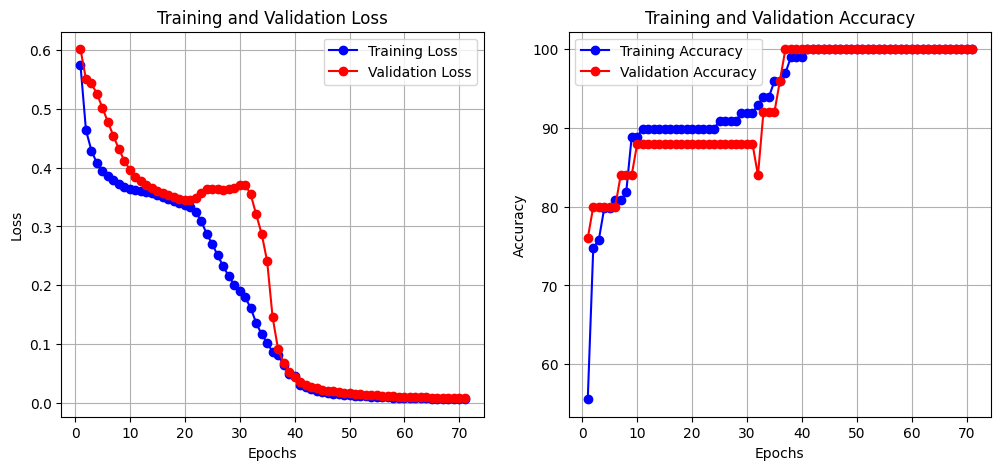

{'learning_rate': np.float64(0.9), 'epochs': np.int64(180), 'batch_size': np.int64(9), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.4), 'regularization': np.float64(0.001), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score: 99.2


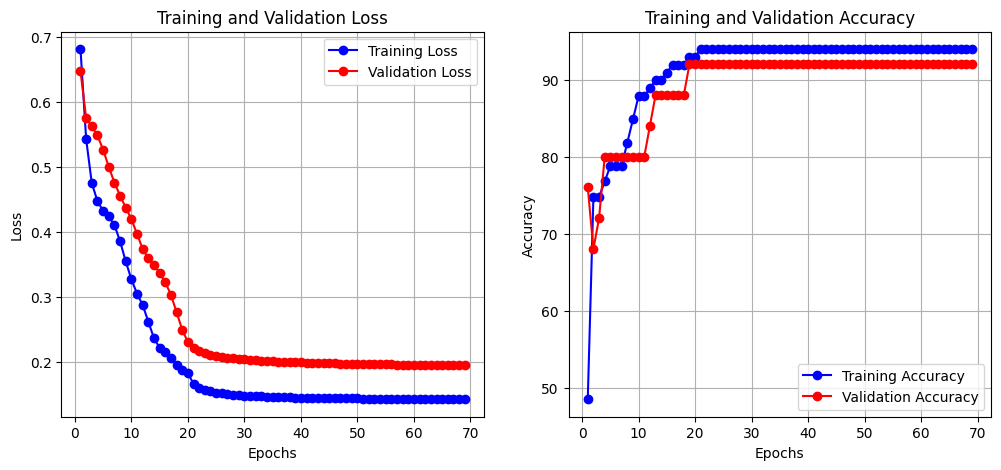

{'learning_rate': np.float64(0.4), 'epochs': np.int64(180), 'batch_size': np.int64(8), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.4), 'regularization': np.float64(0.001), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score: 99.2


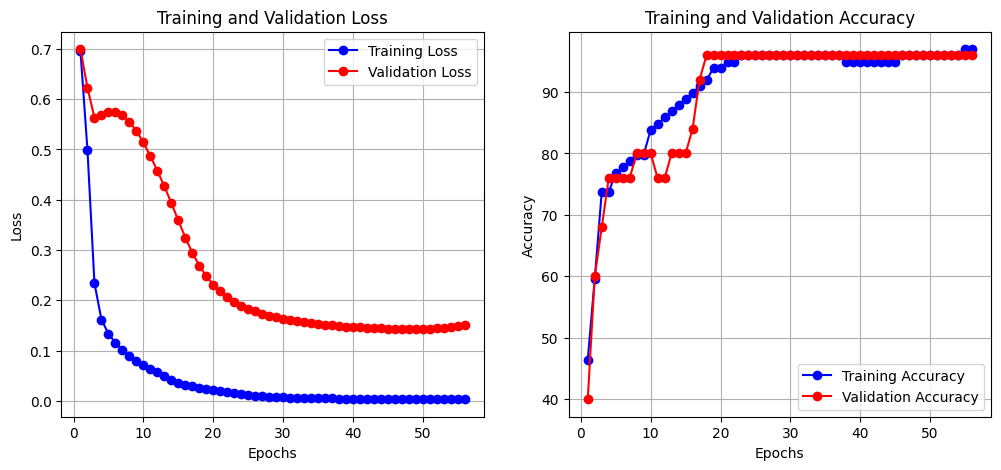

{'learning_rate': np.float64(0.9), 'epochs': np.int64(180), 'batch_size': np.int64(16), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.4), 'regularization': np.float64(0.001), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score: 99.2


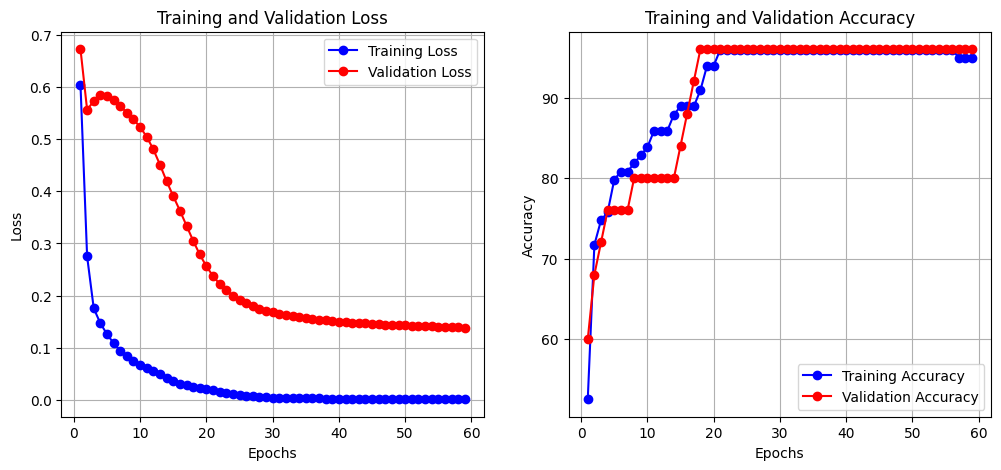

{'learning_rate': np.float64(0.8), 'epochs': np.int64(180), 'batch_size': np.int64(14), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.6000000000000001), 'regularization': np.float64(0.001), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score: 98.4


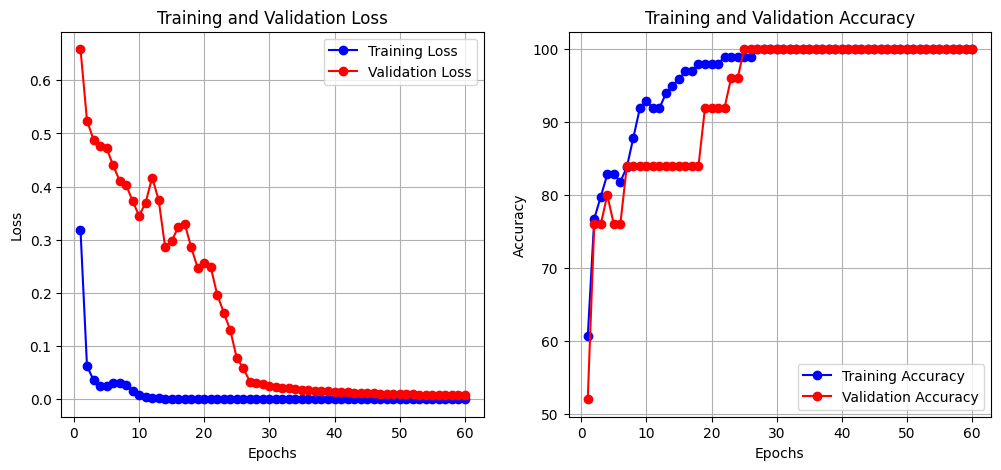

{'learning_rate': np.float64(0.8), 'epochs': np.int64(180), 'batch_size': np.int64(10), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.4), 'regularization': np.float64(0.001), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score: 98.4


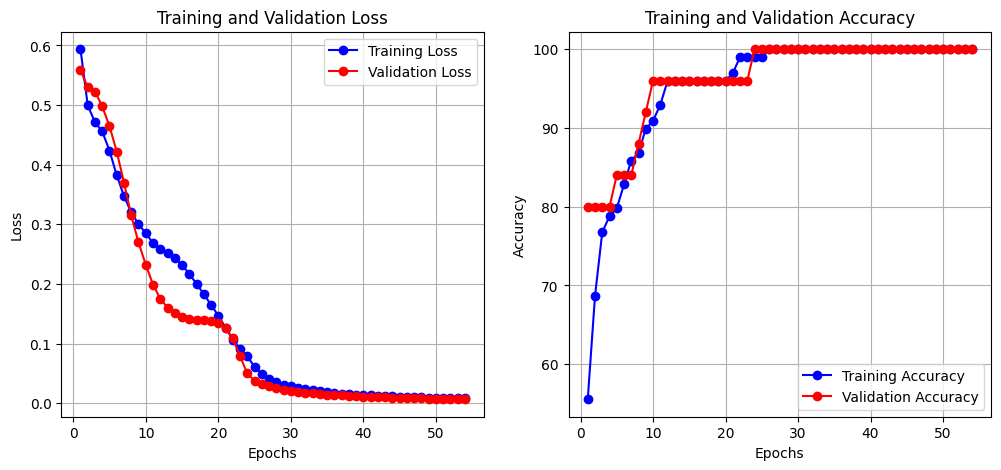

{'learning_rate': np.float64(0.7000000000000001), 'epochs': np.int64(180), 'batch_size': np.int64(5), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.4), 'regularization': np.float64(0.001), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score: 98.4


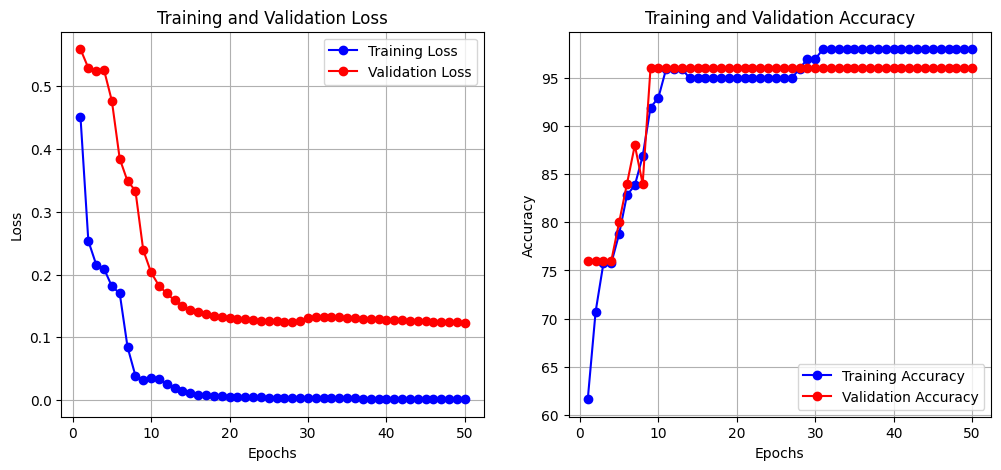

{'learning_rate': np.float64(0.7000000000000001), 'epochs': np.int64(180), 'batch_size': np.int64(5), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.2), 'regularization': np.float64(0.001), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score: 98.4


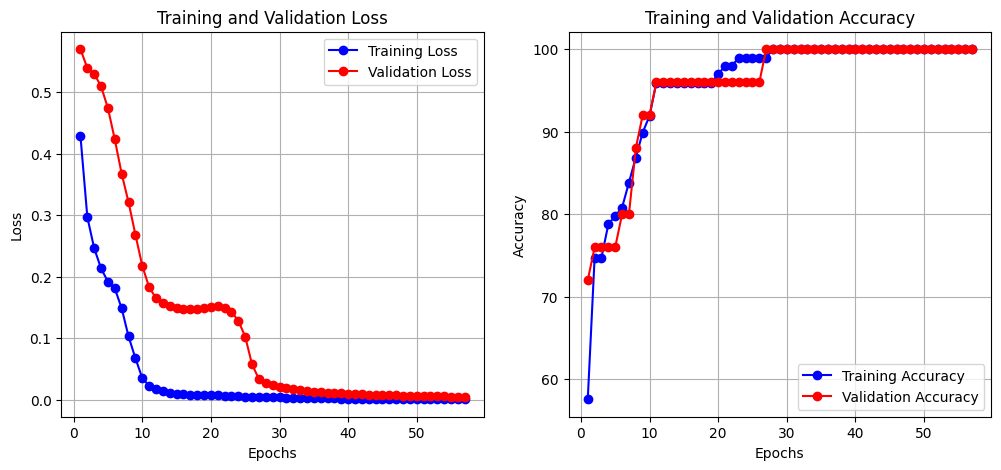

{'learning_rate': np.float64(0.4), 'epochs': np.int64(180), 'batch_size': np.int64(7), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.30000000000000004), 'regularization': np.float64(0.001), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score: 98.4


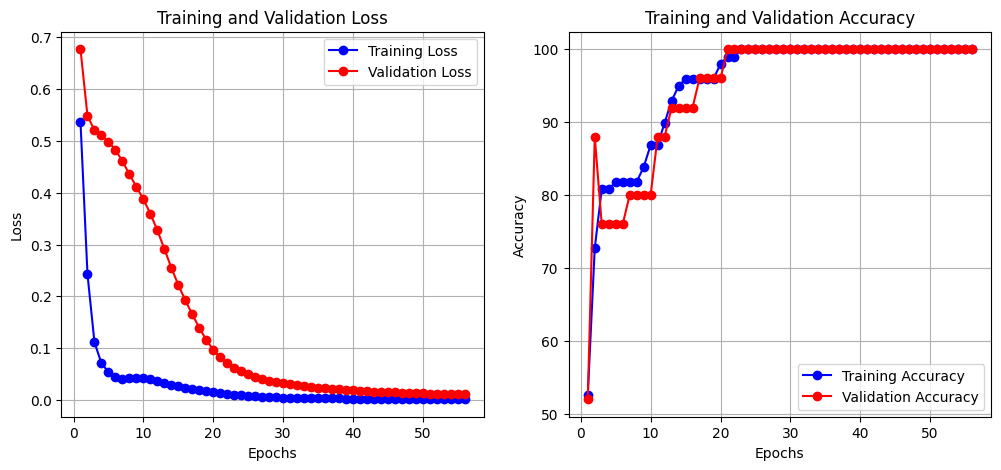

{'learning_rate': np.float64(0.2), 'epochs': np.int64(180), 'batch_size': np.int64(8), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.8), 'regularization': np.float64(0.001), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score: 98.4


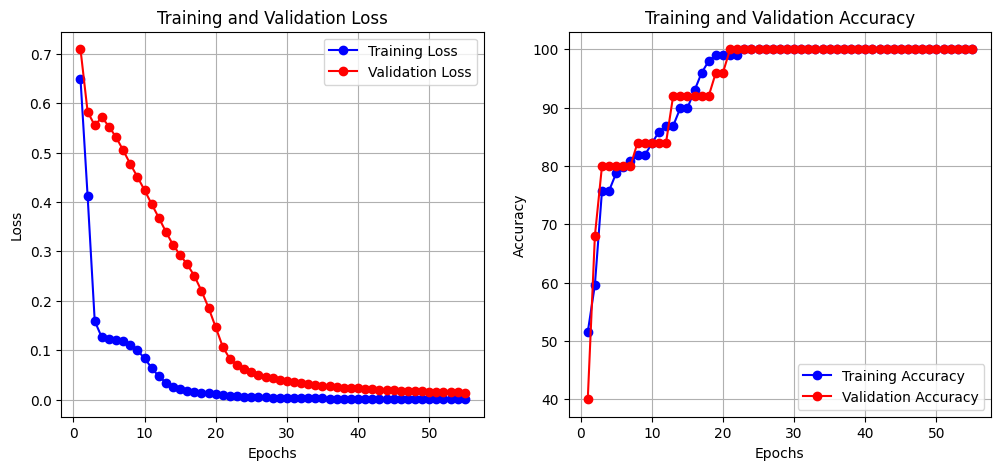

In [145]:
# Initialize lists to store the best scores, parameters, models, and training histories for each dataset
best_scores = [[], [], []]  # Use a list of three elements to store the scores for each dataset
best_params_list = [[], [], []]  # List of three elements to store the best hyperparameter configurations for each dataset
best_models = [[], [], []]  # List of three elements to store the best models for each dataset
best_histories = [[], [], []]  # List of three elements to store the training histories for each dataset

# Determine the input size from the encoded training data for monk1
input_size = X1_train_encoded.shape[1]
output_size = 1

# Define the range of hyperparameters for the grid search
param_ranges_1 = {
    "learning_rate": (0.1, 0.9, 0.1),  # Da 0.01 a 0.5 con step di 0.05
    "epochs": (180, 180, 1),                   # Da 0 a 10 con step di 1
    "batch_size": (4, 16, 1),             # Da 8 a 32 con step di 8
    "hidden_size": (3, 3, 1),           # Da 32 a 128 con step di 32
    "hidden_layers": (1, 1, 1),             # Da 1 a 3 con step di 1
    "momentum": (0.1, 0.9, 0.1),          # Da 0.9 a 0.99 con step di 0.01
    "regularization": (0.001, 0.001, 0.005),             # Da 0.0 a 0.1 con step di 0.05
    "alpha": (0.01, 0.01, 0.01),             # Da 0.01 a 0.1 con step di 0.05
    "patience": (30, 30, 1)            # Da 5 a 15 con step di 5
}

# Generate all combinations of hyperparameters based on the specified ranges
print("Generazione delle combinazioni di iperparametri...")
param_grid_monk1 = []
param_grid_monk1 = generate_hyperparameter_combinations(param_ranges_1)


print("--------------------------------------------------MONK 1--------------------------------------------------")
# Perform a greedy search over the hyperparameter grid for monk1 dataset
best_scores[0], best_params_list[0], best_models[0], best_histories[0] = greed_search(X1_train_encoded, y1_train, 
                                                                                      'tanh', 'SGD', False, 
                                                                                      input_size, output_size, param_grid_monk1)

print("--------------------------------------------------Plots--------------------------------------------------")
# Iterate over the best histories, parameters, and scores to print and plot the results
for i, (history, params, score) in enumerate(zip(best_histories[0], best_params_list[0], best_scores[0])):
    print(f"{params}")
    print(f"Score: {score}")
    plot_training_history(history)

Generazione delle combinazioni di iperparametri...
--------------------------------------------------MONK 2--------------------------------------------------
--------------------------------------------------
Testing params: {'learning_rate': np.float64(0.1), 'epochs': np.int64(180), 'batch_size': np.int64(4), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.1), 'regularization': np.float64(0.001), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score : 98.23529411764706
--------------------------------------------------
Testing params: {'learning_rate': np.float64(0.1), 'epochs': np.int64(180), 'batch_size': np.int64(4), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.2), 'regularization': np.float64(0.001), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score : 93.52941176470588
--------------------------------------------------
Testing params: {'learning_rate': np.float64(0.1), 'epochs': np.int64(180), '

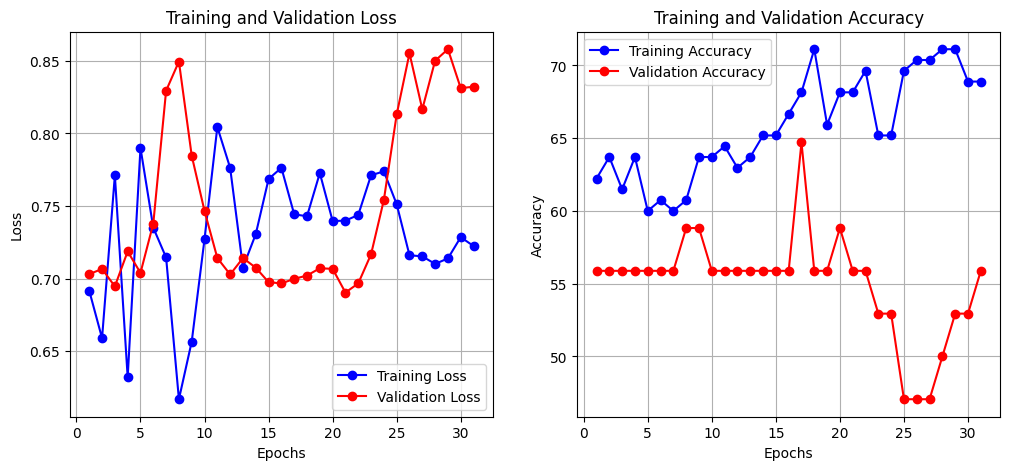

{'learning_rate': np.float64(0.9), 'epochs': np.int64(180), 'batch_size': np.int64(10), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.4), 'regularization': np.float64(0.001), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score: 100.0


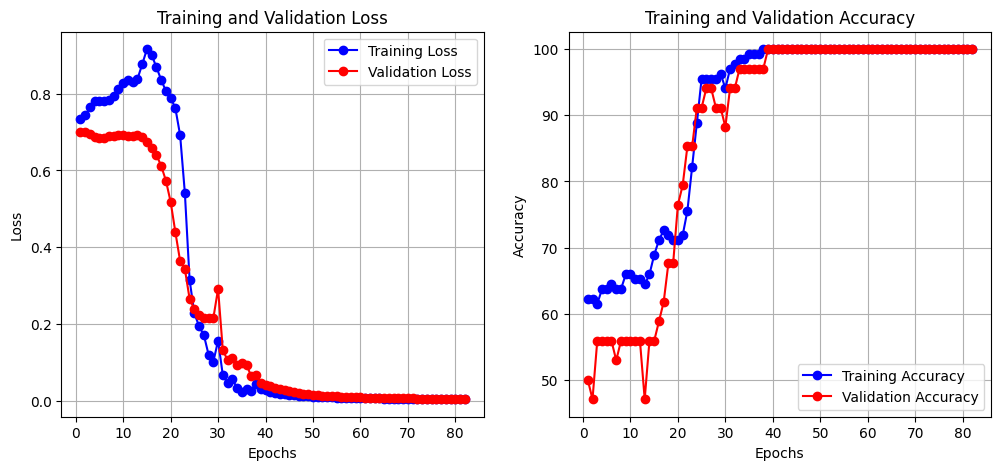

{'learning_rate': np.float64(0.6000000000000001), 'epochs': np.int64(180), 'batch_size': np.int64(16), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.8), 'regularization': np.float64(0.001), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score: 100.0


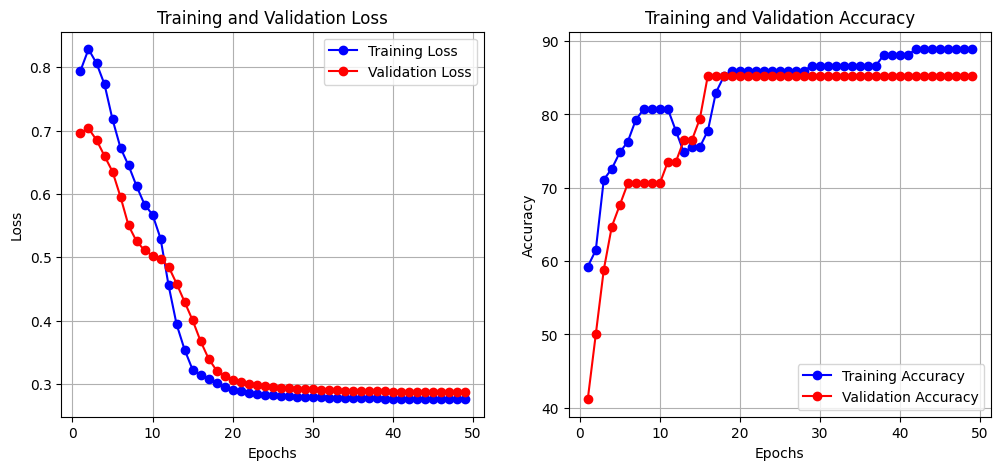

{'learning_rate': np.float64(0.1), 'epochs': np.int64(180), 'batch_size': np.int64(4), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.9), 'regularization': np.float64(0.001), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score: 100.0


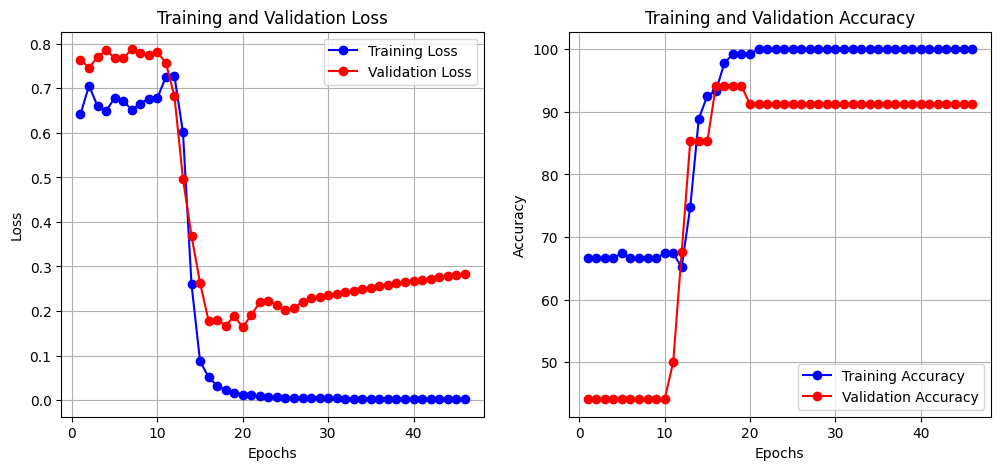

{'learning_rate': np.float64(0.1), 'epochs': np.int64(180), 'batch_size': np.int64(4), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.5), 'regularization': np.float64(0.001), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score: 100.0


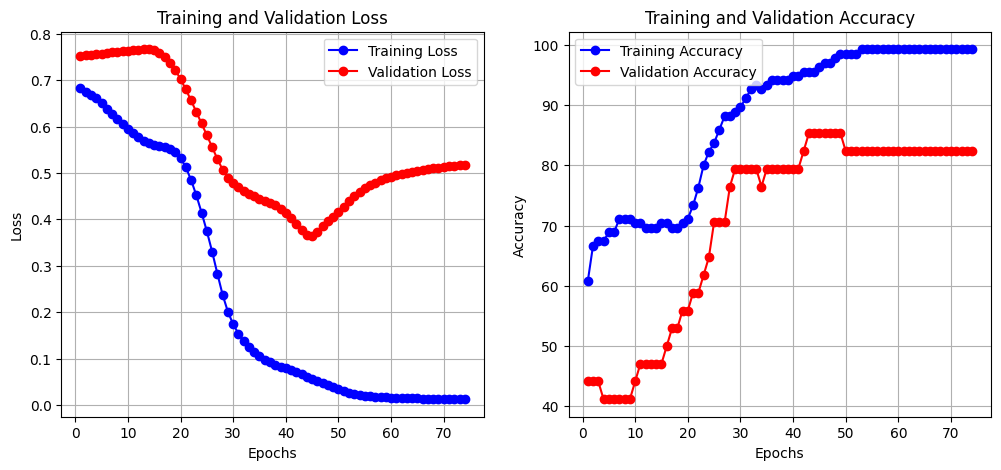

{'learning_rate': np.float64(0.1), 'epochs': np.int64(180), 'batch_size': np.int64(10), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.9), 'regularization': np.float64(0.001), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score: 100.0


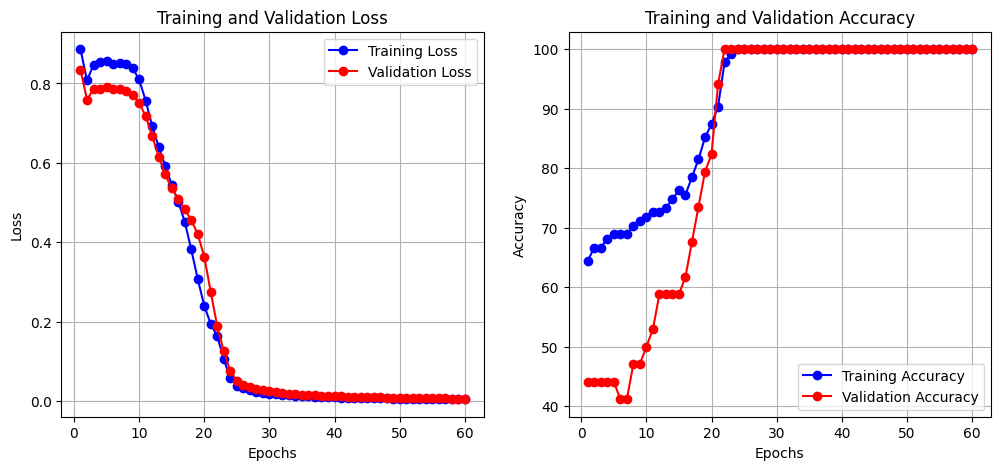

{'learning_rate': np.float64(0.2), 'epochs': np.int64(180), 'batch_size': np.int64(10), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.6000000000000001), 'regularization': np.float64(0.001), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score: 100.0


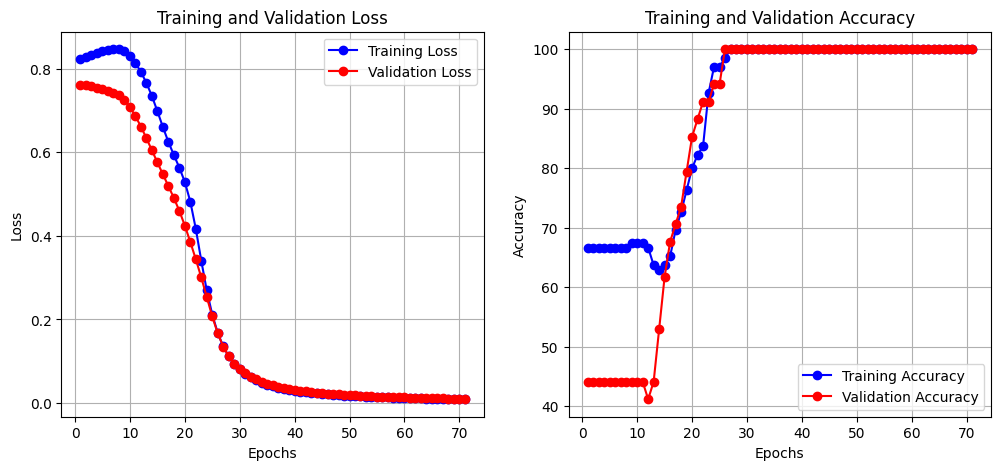

{'learning_rate': np.float64(0.30000000000000004), 'epochs': np.int64(180), 'batch_size': np.int64(4), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.2), 'regularization': np.float64(0.001), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score: 100.0


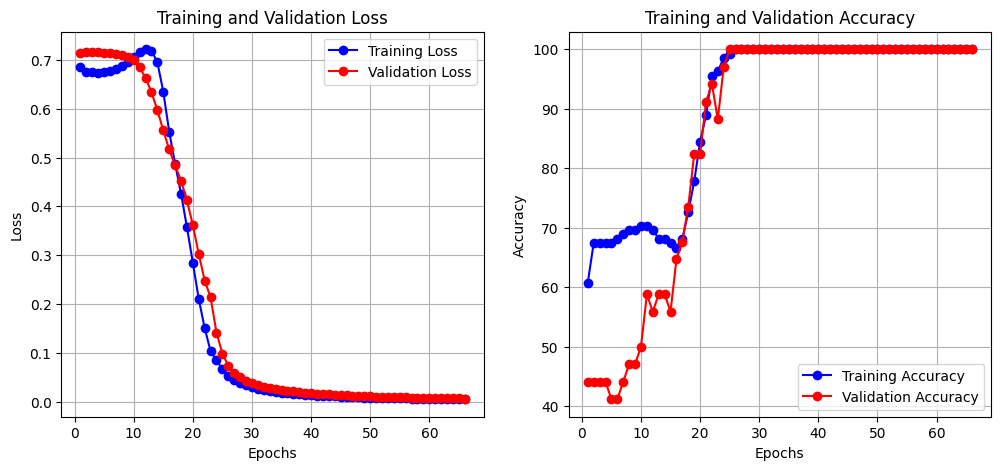

{'learning_rate': np.float64(0.4), 'epochs': np.int64(180), 'batch_size': np.int64(10), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.8), 'regularization': np.float64(0.001), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score: 100.0


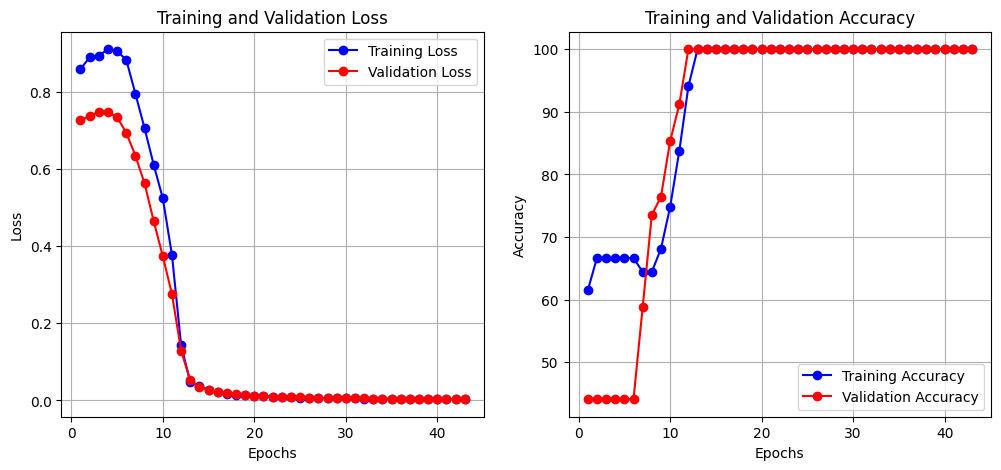

{'learning_rate': np.float64(0.4), 'epochs': np.int64(180), 'batch_size': np.int64(16), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.9), 'regularization': np.float64(0.001), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score: 100.0


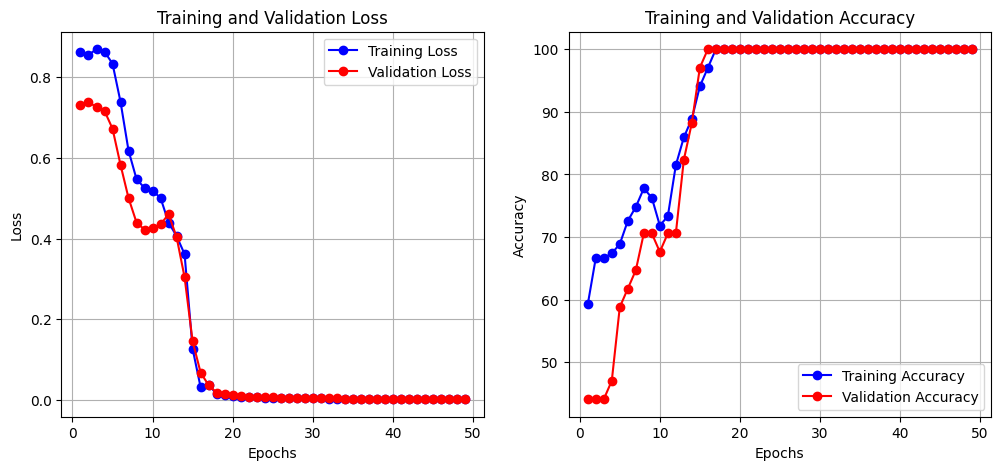

In [146]:
# Determine the input size from the encoded training data for monk2
input_size = X2_train_encoded.shape[1]
output_size = 1

# Define the range of hyperparameters for the grid search
param_ranges_2 = {
    "learning_rate": (0.1, 0.9, 0.1),  # Da 0.01 a 0.5 con step di 0.05
    "epochs": (180, 180, 1),                   # Da 0 a 10 con step di 1
    "batch_size": (4, 16, 6),             # Da 8 a 32 con step di 8
    "hidden_size": (3, 3, 1),           # Da 32 a 128 con step di 32
    "hidden_layers": (1, 1, 1),             # Da 1 a 3 con step di 1
    "momentum": (0.1, 0.9, 0.1),          # Da 0.9 a 0.99 con step di 0.01
    "regularization": (0.001, 0.001, 0.005),             # Da 0.0 a 0.1 con step di 0.05
    "alpha": (0.01, 0.01, 0.01),             # Da 0.01 a 0.1 con step di 0.05
    "patience": (30, 30, 1)            # Da 5 a 15 con step di 5
}

# Generate all combinations of hyperparameters based on the specified ranges
print("Generazione delle combinazioni di iperparametri...")
param_grid_monk2 = []
param_grid_monk2 = generate_hyperparameter_combinations(param_ranges_2)


print("--------------------------------------------------MONK 2--------------------------------------------------")
# Perform a greedy search over the hyperparameter grid for monk2 dataset
best_scores[1], best_params_list[1], best_models[1], best_histories[1] = greed_search(X2_train_encoded, y2_train, 
                                                                                      'tanh', 'SGD', False, 
                                                                                      input_size, output_size, param_grid_monk2)

print("--------------------------------------------------Plots--------------------------------------------------")
# Iterate over the best histories, parameters, and scores to print and plot the results
for i, (history, params, score) in enumerate(zip(best_histories[1], best_params_list[1], best_scores[1])):
    print(f"{params}")
    print(f"Score: {score}")
    plot_training_history(history)

Generazione delle combinazioni di iperparametri...
--------------------------------------------------MONK 3--------------------------------------------------
--------------------------------------------------
Testing params: {'learning_rate': np.float64(0.1), 'epochs': np.int64(180), 'batch_size': np.int64(4), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.1), 'regularization': np.float64(0.1), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score : 93.43333333333332
--------------------------------------------------
Testing params: {'learning_rate': np.float64(0.1), 'epochs': np.int64(180), 'batch_size': np.int64(4), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.1), 'regularization': np.float64(0.30000000000000004), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score : 50.8
--------------------------------------------------
Testing params: {'learning_rate': np.float64(0.1), 'epochs': np.int64(180), 'b

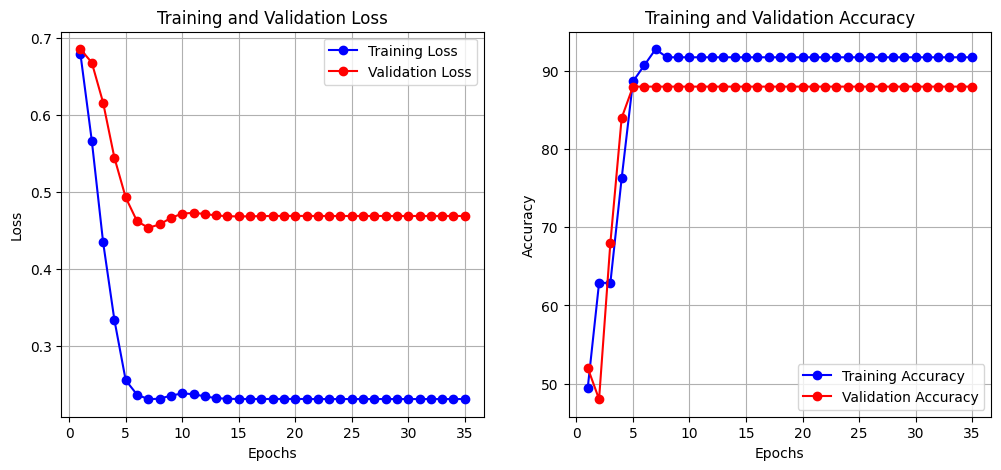

{'learning_rate': np.float64(0.2), 'epochs': np.int64(180), 'batch_size': np.int64(10), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.1), 'regularization': np.float64(0.1), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score: 93.43333333333332


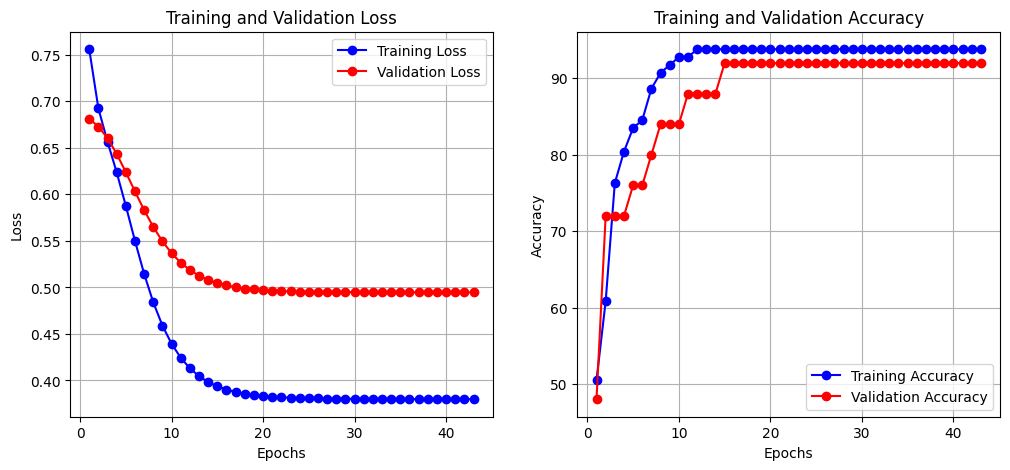

{'learning_rate': np.float64(0.2), 'epochs': np.int64(180), 'batch_size': np.int64(10), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.2), 'regularization': np.float64(0.1), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score: 93.43333333333332


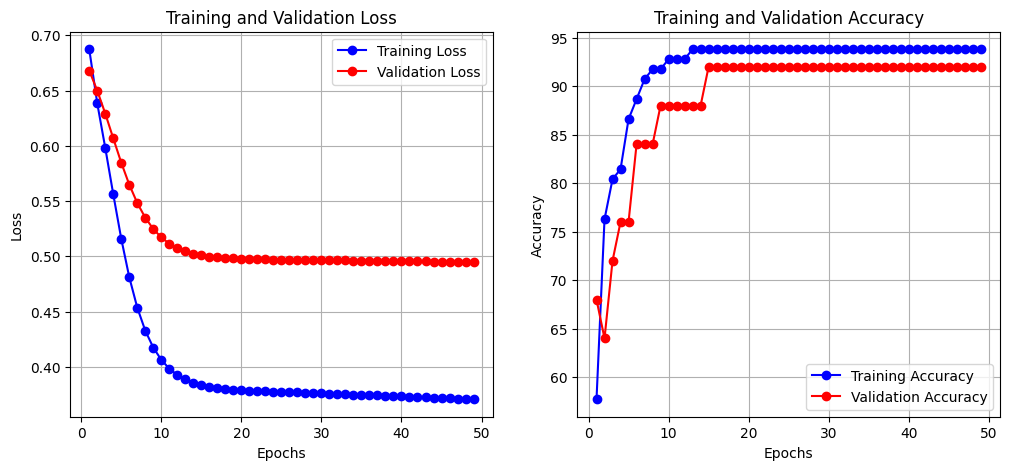

{'learning_rate': np.float64(0.2), 'epochs': np.int64(180), 'batch_size': np.int64(10), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.30000000000000004), 'regularization': np.float64(0.1), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score: 93.43333333333332


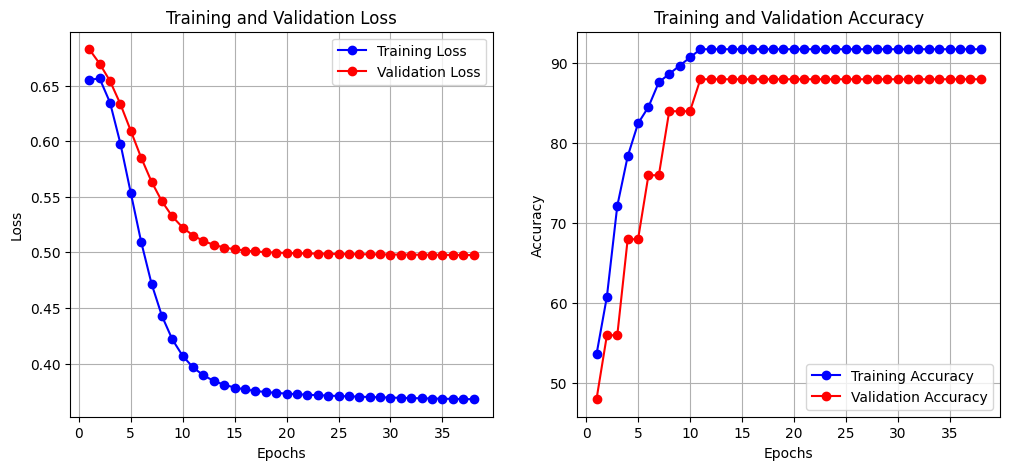

{'learning_rate': np.float64(0.2), 'epochs': np.int64(180), 'batch_size': np.int64(10), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.4), 'regularization': np.float64(0.1), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score: 93.43333333333332


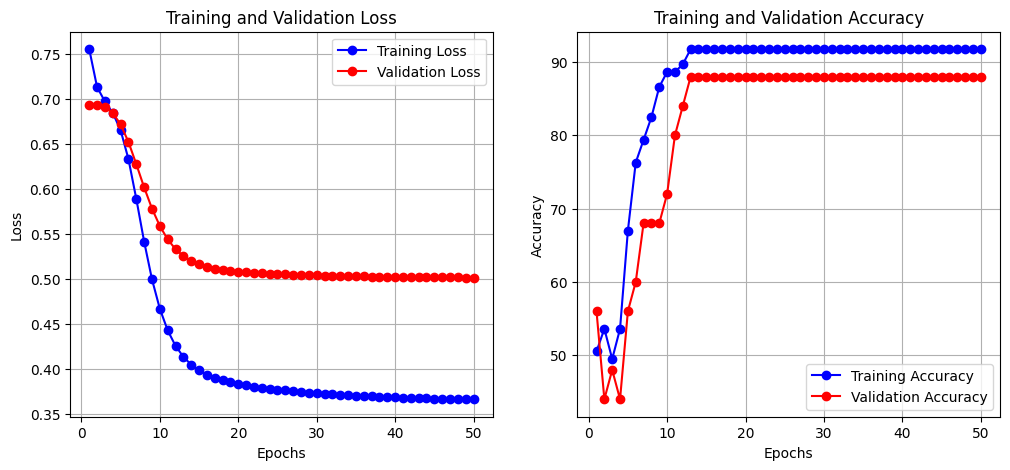

{'learning_rate': np.float64(0.2), 'epochs': np.int64(180), 'batch_size': np.int64(10), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.5), 'regularization': np.float64(0.1), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score: 93.43333333333332


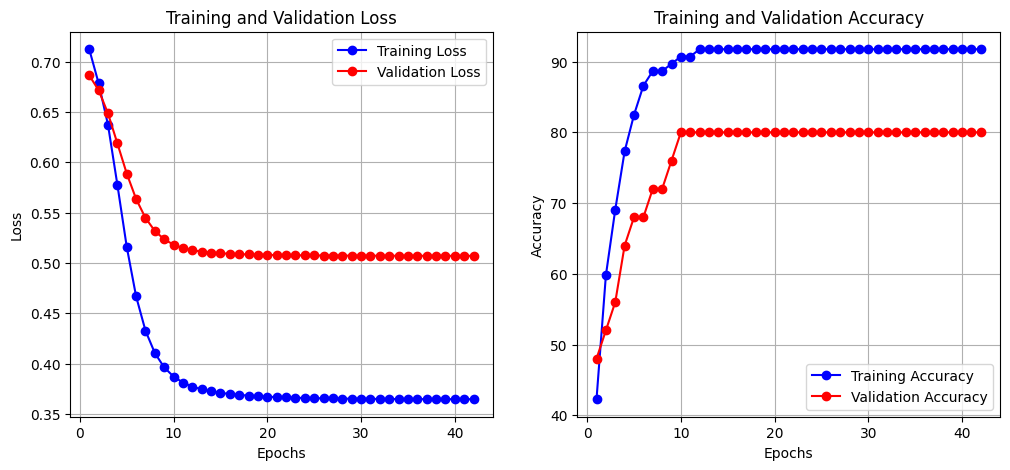

{'learning_rate': np.float64(0.2), 'epochs': np.int64(180), 'batch_size': np.int64(10), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.6000000000000001), 'regularization': np.float64(0.1), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score: 93.43333333333332


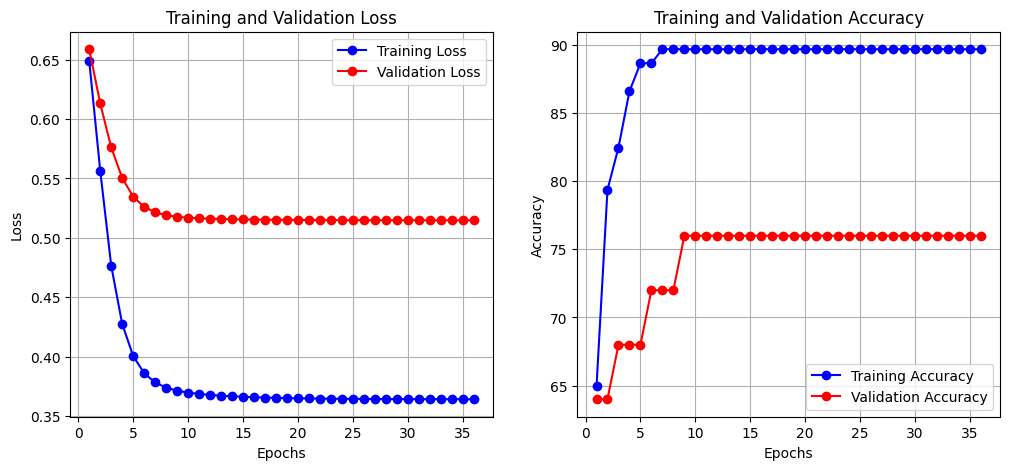

{'learning_rate': np.float64(0.2), 'epochs': np.int64(180), 'batch_size': np.int64(10), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.7000000000000001), 'regularization': np.float64(0.1), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score: 93.43333333333332


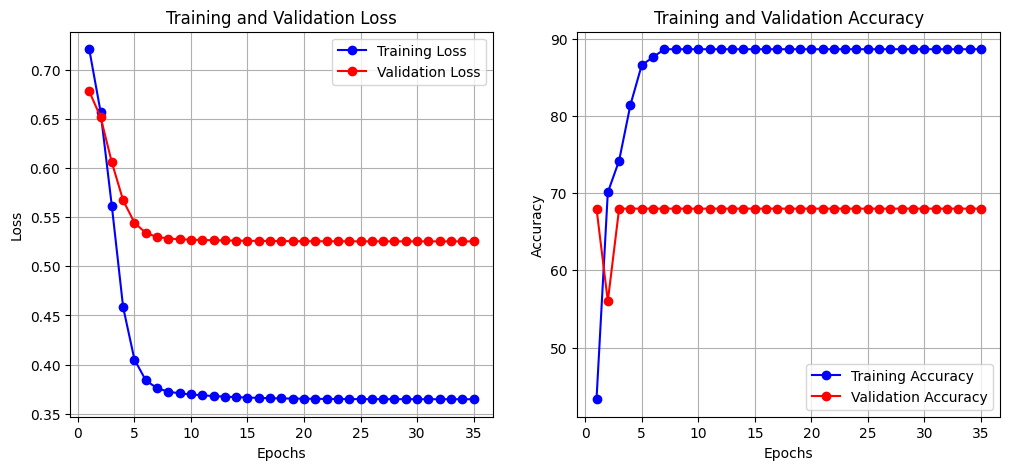

{'learning_rate': np.float64(0.2), 'epochs': np.int64(180), 'batch_size': np.int64(10), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.8), 'regularization': np.float64(0.1), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score: 93.43333333333332


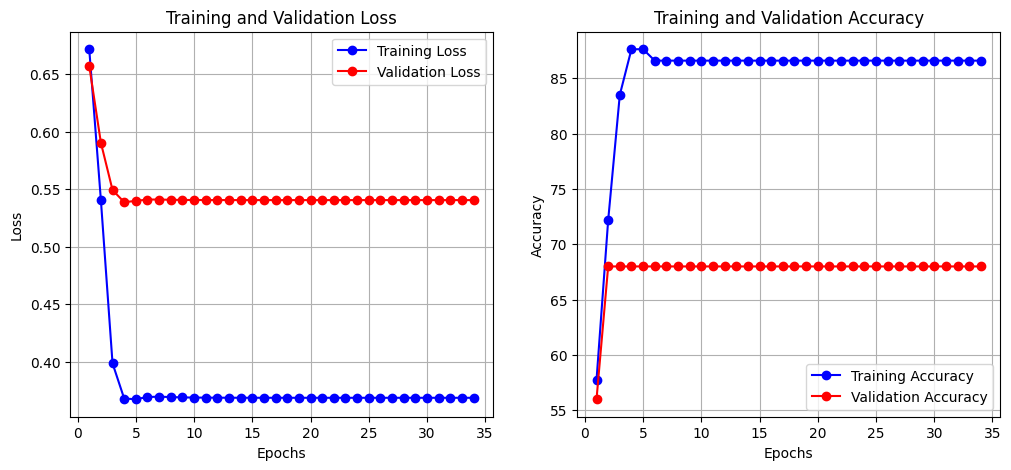

{'learning_rate': np.float64(0.2), 'epochs': np.int64(180), 'batch_size': np.int64(10), 'hidden_size': np.int64(3), 'hidden_layers': np.int64(1), 'momentum': np.float64(0.9), 'regularization': np.float64(0.1), 'alpha': np.float64(0.01), 'patience': np.int64(30)}
Score: 93.43333333333332


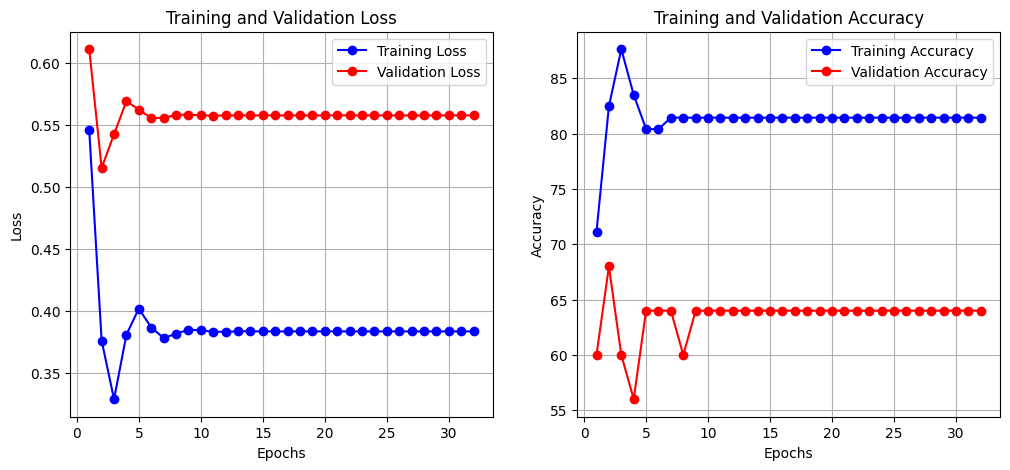

In [155]:
# Determine the input size from the encoded training data for monk3
input_size = X3_train_encoded.shape[1]
output_size = 1

# Define the range of hyperparameters for the grid search
param_ranges_3 = {
    "learning_rate": (0.1, 0.9, 0.1),  # Da 0.01 a 0.5 con step di 0.05
    "epochs": (180, 180, 1),                   # Da 0 a 10 con step di 1
    "batch_size": (4, 16, 6),             # Da 8 a 32 con step di 8
    "hidden_size": (3, 3, 1),           # Da 32 a 128 con step di 32
    "hidden_layers": (1, 1, 1),             # Da 1 a 3 con step di 1
    "momentum": (0.1, 0.9, 0.1),          # Da 0.9 a 0.99 con step di 0.01
    "regularization": (0.1, 0.1, 0.2),             # Da 0.0 a 0.1 con step di 0.05
    "alpha": (0.01, 0.01, 0.01),             # Da 0.01 a 0.1 con step di 0.05
    "patience": (30, 30, 1)            # Da 5 a 15 con step di 5
}

# Generate all combinations of hyperparameters based on the specified ranges
print("Generazione delle combinazioni di iperparametri...")
param_grid_monk3 = []
param_grid_monk3 = generate_hyperparameter_combinations(param_ranges_3)


print("--------------------------------------------------MONK 3--------------------------------------------------")
# Perform a greedy search over the hyperparameter grid for monk3 dataset
best_scores[2], best_params_list[2], best_models[2], best_histories[2] = greed_search(X3_train_encoded, y3_train, 
                                                                                      'tanh', 'SGD', True, 
                                                                                      input_size, output_size, param_grid_monk3)

print("--------------------------------------------------Plots--------------------------------------------------")
# Iterate over the best histories, parameters, and scores to print and plot the results
for i, (history, params, score) in enumerate(zip(best_histories[2], best_params_list[2], best_scores[2])):
    print(f"{params}")
    print(f"Score: {score}")
    plot_training_history(history)

In [151]:
# Generate all combinations of hyperparameters based on the specified ranges
param_grid_final_monk1 = [best_params_list[0][1]]

scores_monk1, _ = double_k_fold_cross_validation(X1_train_encoded, y1_train, activ_type= 'tanh', optim_type = 'sgd', reg_flag = False, input_size = X1_train_encoded.shape[1], output_size=1, outer_k = 5, inner_k = 5, param_grid=param_grid_final_monk1)

print(scores_monk1)
variance_1 = np.var(scores_monk1)
mean_monk1 = np.mean(scores_monk1)

print(f"Mean MONK 1: {mean_monk1}")
print(f"Variance MONK 1: {variance_1}")

[100.0, 100.0, 100.0, 100.0, 100.0]
Mean MONK 1: 100.0
Variance MONK 1: 0.0


In [185]:
# Generate all combinations of hyperparameters based on the specified ranges
param_grid_final_monk2 = [best_params_list[1][6]]

scores_monk2, _ = double_k_fold_cross_validation(X2_train_encoded, y2_train, activ_type= 'tanh', optim_type = 'sgd', reg_flag = False, input_size = X2_train_encoded.shape[1], output_size=1, outer_k = 5, inner_k = 5, param_grid=param_grid_final_monk2)


print(scores_monk2)
variance_2 = np.var(scores_monk2)
mean_monk2 = np.mean(scores_monk2)

print(f"Mean MONK 2: {mean_monk2}")
print(f"Variance MONK 2: {variance_2}")



[100.0, 100.0, 100.0, 100.0, 100.0]
Mean MONK 2: 100.0
Variance MONK 2: 0.0


In [184]:
# Generate all combinations of hyperparameters based on the specified ranges
param_grid_final_monk3 = [best_params_list[2][1]]

scores_monk3, _ = double_k_fold_cross_validation(X3_train_encoded, y3_train, activ_type= 'tanh', optim_type = 'sgd', reg_flag = True, input_size = X3_train_encoded.shape[1], output_size=1, outer_k = 5, inner_k = 5, param_grid=param_grid_final_monk3)
print(scores_monk3)
variance_3 = np.var(scores_monk3)
mean_monk3 = np.mean(scores_monk3)

print(f"Mean MONK 3: {mean_monk3}")
print(f"Variance MONK 3: {variance_3}")

[100.0, 88.0, 95.83333333333333, 87.5, 95.83333333333333]
Mean MONK 3: 93.43333333333332
Variance MONK 3: 23.873333333333328
